# Test Trotterization on FakeJakarta with QREM and ZNE

- Status: OK

# Import Libiraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import itertools
from pprint import pprint
import pickle
import time
import datetime

In [2]:
# Import qubit states Zero (|0>) and One (|1>), and Pauli operators (X, Y, Z)
from qiskit.opflow import Zero, One, I, X, Y, Z
from qiskit import QuantumCircuit, QuantumRegister, IBMQ, execute, transpile, Aer
from qiskit.tools.monitor import job_monitor
from qiskit.circuit import Parameter
from qiskit.transpiler.passes import RemoveBarriers

In [3]:
# Import QREM package
from qiskit.ignis.mitigation.measurement import complete_meas_cal, CompleteMeasFitter
from qiskit.ignis.mitigation import expectation_value

/var/folders/vr/d82vcp297v78vk4sb0_nzzdc0000gn/T/ipykernel_46343/3056705909.py:2: DeprecationWarning: The qiskit.ignis package is deprecated and has been supersceded by the qiskit-experiments project. Refer to the migration guide: https://github.com/Qiskit/qiskit-ignis#migration-guide on how to migrate to the new project.
  from qiskit.ignis.mitigation.measurement import complete_meas_cal, CompleteMeasFitter


In [4]:
# Import mitiq for zne
import mitiq

In [5]:
# Import state tomography modules
from qiskit.ignis.verification.tomography import state_tomography_circuits, StateTomographyFitter
from qiskit.quantum_info import state_fidelity

# Import Libraries

In [6]:
import sys
import importlib
sys.path.append("../utils/")
import circuit_utils, zne_utils, tomography_utils, sgs_algorithm
importlib.reload(circuit_utils)
importlib.reload(zne_utils)
importlib.reload(tomography_utils)
importlib.reload(sgs_algorithm)
from circuit_utils import *
from zne_utils import *
from tomography_utils import *
from sgs_algorithm import *

# Set Parameters

In [10]:
# Combine subcircuits into a single multiqubit gate representing a single trotter step
num_qubits = 3

# The final time of the state evolution
target_time = np.pi

# Parameterize variable t to be evaluated at t=pi later
dt = Parameter('2t/n')

# Convert custom quantum circuit into a gate
trot_gate = trotter_gate(dt)

# initial layout
initial_layout = [5,3,1]

# Number of trotter steps
num_steps = 4
print("trotter step: ", num_steps)

scale_factors = [1.0, 2.0, 3.0]

trotter step:  4


# Prepare Circuits

logical circuits = little endian
name: lq = logical qubits 

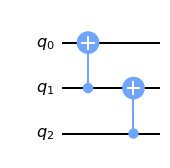

In [11]:
qc = QuantumCircuit(3)
subspace_decoder(qc, targets=[0, 1, 2])
qc.draw("mpl")

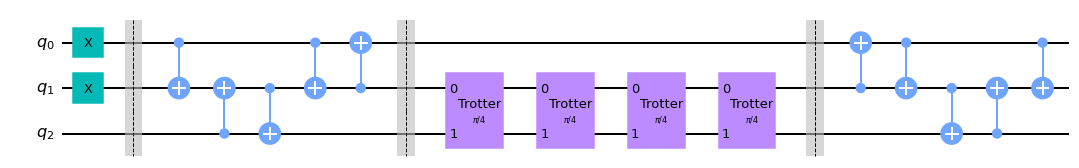

In [21]:
# Initialize quantum circuit for 3 qubits
# qr = QuantumRegister(num_qubits, name="q")

qc = QuantumCircuit(3)

# Prepare initial state (remember we are only evolving 3 of the 7 qubits on jakarta qubits (q_5, q_3, q_1) corresponding to the state |110>)
make_initial_state(qc, "110")  # DO NOT MODIFY (|q_5,q_3,q_1> = |110>)
qc.barrier()
general_subspace_encoder(qc, targets=[0, 1, 2]) # encode
qc.barrier()
trotterize(qc, trot_gate, num_steps, targets=[1, 2]) # Simulate time evolution under H_heis3 Hamiltonian
qc.barrier()
general_subspace_decoder(qc, targets=[0, 1, 2]) # decode
qc = qc.bind_parameters({dt: target_time / num_steps})
qc.draw("mpl")

In [12]:
# Initialize quantum circuit for 3 qubits
qr = QuantumRegister(num_qubits, name="q")
qc = QuantumCircuit(qr)

# Prepare initial state (remember we are only evolving 3 of the 7 qubits on jakarta qubits (q_5, q_3, q_1) corresponding to the state |110>)
make_initial_state(qc, "110")  # DO NOT MODIFY (|q_5,q_3,q_1> = |110>)

general_subspace_encoder(qc, targets=[0, 1, 2]) # encode
trotterize(qc, trot_gate, num_steps, targets=[1, 2]) # Simulate time evolution under H_heis3 Hamiltonian
general_subspace_decoder(qc, targets=[0, 1, 2]) # decode

# Evaluate simulation at target_time (t=pi) meaning each trotter step evolves pi/trotter_steps in time
qc = qc.bind_parameters({dt: target_time / num_steps})
print("created qc")

# Generate state tomography circuits to evaluate fidelity of simulation
st_qcs = state_tomography_circuits(qc, [0, 1, 2][::-1])  #! state tomography requires === BIG ENDIAN === 
print("created st_qcs (length:", len(st_qcs), ")")

# remove barriers
st_qcs = [RemoveBarriers()(qc) for qc in st_qcs]
print("removed barriers from st_qcs")

# optimize circuit
t3_st_qcs = transpile(st_qcs, optimization_level=3, basis_gates=["sx", "cx", "rz"])
t3_st_qcs = transpile(t3_st_qcs, optimization_level=3, basis_gates=["sx", "cx", "rz"])
print("created t3_st_qcs (length:", len(t3_st_qcs), ")")

# zne wrapping
zne_qcs = t3_st_qcs
# zne_qcs = zne_wrapper(t3_st_qcs, scale_factors = scale_factors, pt = False)
# print("created zne_qcs (length:", len(zne_qcs), ")")

# optimization_level must be 0
# feed initial_layout here to see the picture of the circuits before casting the job
t3_zne_qcs = transpile(zne_qcs, optimization_level=0, basis_gates=["sx", "cx", "rz"], initial_layout=initial_layout)
print("created t3_zne_qcs (length:", len(t3_zne_qcs), ")")

created qc
created st_qcs (length: 27 )
removed barriers from st_qcs


KeyboardInterrupt: 

In [ ]:
qc

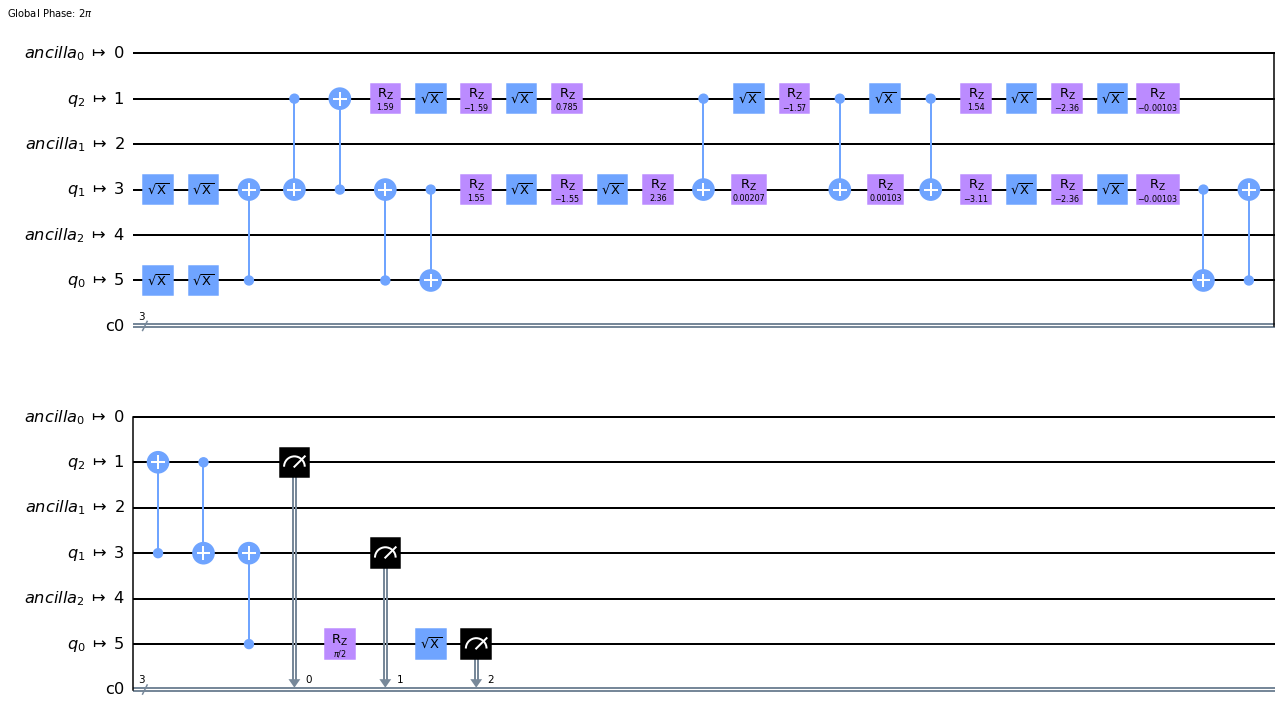

In [9]:
t3_zne_qcs[-3].draw("mpl")

# Set Backend